In [1]:
# --- Import tools/libaries --- #

# Python libararies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import array

import time
from pandas import Series
from numpy import mean
from math import sqrt
from sklearn.metrics import mean_squared_error


# Spark libararies
from pyspark.sql.types import DoubleType  # Used to change data type
import pyspark.sql.functions as F
import pyspark.sql.window as W

In [2]:
# --- Data preparation --- #

# import data and select the desired data
raw_data = spark.read.format('csv').options(header='true', inferSchema='true').load('/FileStore/tables/AAPL.csv').drop('Open', 'High', 'Low', 'Adj Close', 'Volume')
raw_data.show(5)

# verify if there is null in the data and drop the null row
raw_data.count()
raw_data.filter(raw_data.Close == "null").count()
raw_data1 = raw_data.filter(raw_data.Close != "null")
raw_data1.count()

# change the close price from string to double
df = raw_data1.withColumn("Close",raw_data1["Close"].cast(DoubleType()))
df.printSchema()

# convert to pandas DataFrame for python use
df1 = df.toPandas()
ts1 = df1["Close"].values

+----------+--------+
 Date| Close|
+----------+--------+
12/12/1980|0.513393|
12/15/1980|0.486607|
12/16/1980|0.450893|
12/17/1980|0.462054|
12/18/1980|0.475446|
+----------+--------+
only showing top 5 rows

root
-- Date: string (nullable = true)
-- Close: double (nullable = true)

In [3]:
# --- Data over varied horizon --- #

# Function to create new time series according to required horizon
def SeriesGenerator(ts,period):
  new_ts = np.array([])
  for i in range(0,len(ts),period):
    if i + period <= len(ts):
      new_ts = np.append(new_ts,ts[i])
    else:
      break
  return new_ts

# Time serieses over varied horizon
ts_daily = SeriesGenerator(ts1,1)
ts_weekly = SeriesGenerator(ts1,5)
ts_biweekly = SeriesGenerator(ts1,10)
ts_monthly = SeriesGenerator(ts1,20)
ts_quamonthly = SeriesGenerator(ts1,40)

In [4]:
# --- Modelling --- #

# Single Exponential Smoothing Model
def SES(obs,alpha):
    # Set the alpha to tune the model. Optimization could be improved by varying the values. 0.1 is a relatively proper value.
    a = alpha
    # prepare the list to store predictions
    pred = list()
    pred.append(obs[0]) # fill in the first element as no inital prediction, same as observation
    # Single Exponential Smoothing method deployed
    for i in range(1,len(obs),1):
        predx = a * obs[i] + (1-a) * pred[i-1]
        pred.append(predx)
    return pred;

  
# Holt't Linear Trend Model (aka double exponential method)
def DES(obs, alpha, beta):
    # prepare the values
    # trend
    trd = list()
    trd.append(0)
    # level 
    lvl = list()
    lvl.append(obs[0])
    # prediction: fill in the first two elements as no inital prediction, same as observation
    pred = list()
    pred.append(obs[0])
    pred.append(obs[0])
    # Holt't Linear Trend method deployed
    for i in range(2,len(obs),1):
      lvlx = alpha * obs[i-1] + (1 - alpha) * (lvl[i-2] + trd[i-2])
      lvl.append(lvlx)
      trdx = beta * (lvl[i-1] - lvl[i-2]) + (1 - beta) * trd[i-2]
      trd.append(trdx)
      predx = lvl[i-1] + trd[i-1]
      pred.append(predx)
    return pred; 

In [5]:
# --- Analysis --- #

# RMSE(Root Mean Squared Error) define
def RMSE(observations, predictions):
  mse = mean_squared_error(observations, predictions)
  rmse = sqrt(mse)
  return rmse;

# SMAPE(Symmetric mean absolute percentage error) define
def SMAPE(observations, predictions):
    smape = 100/len(observations) * np.sum(2 * np.abs(predictions - observations) / (np.abs(observations) + np.abs(predictions))) # in %
    return smape;

In [6]:
# --- Optimization --- #

# find the minimum RMSE/SMAPE by varying a/b 

def MinSelection_SES_RMSE(obs,accuracy):
  best_result = RMSE(obs,SES(obs,accuracy))
  best_accuracy = accuracy
  rng = int(1/accuracy-1)
  for i in range(1,rng,1):
      result = RMSE(obs,SES(obs,i*accuracy))
      if result < best_result:
          best_result = result
          best_a = i*accuracy
  best_pred = SES(obs,best_a)
  return [best_result,best_pred,best_a]

def MinSelection_SES_SMAPE(obs,accuracy):
  best_result = SMAPE(obs,SES(obs,accuracy))
  best_accuracy = accuracy
  rng = int(1/accuracy-1)
  for i in range(1,rng,1):
      result = SMAPE(obs,SES(obs,i*accuracy))
      if result < best_result:
          best_result = result
          best_a = i*accuracy
  best_pred = SES(obs,best_a)
  return [best_result,best_pred,best_a]

def MinSelection_DES_RMSE(obs,accuracy):
  best_a = accuracy
  best_b = accuracy
  best_result = RMSE(obs,DES(obs,best_a,best_b))
  rng = int(1/accuracy-1)
  for i in range(1,rng,1):
      for j in range(1,rng,1):
          result = RMSE(obs,DES(obs,i*accuracy,j*accuracy))
          if result < best_result:
              best_result = result
              best_a = i*accuracy
              best_b = j*accuracy
  best_pred = DES(obs,best_a,best_b)
  return [best_result,best_pred,best_a,best_b]

def MinSelection_DES_SMAPE(obs,accuracy):
  best_a = accuracy
  best_b = accuracy
  best_result = SMAPE(obs,DES(obs,best_a,best_b))
  rng = int(1/accuracy-1)
  for i in range(1,rng,1):
      for j in range(1,rng,1):
          result = SMAPE(obs,DES(obs,i*accuracy,j*accuracy))
          if result < best_result:
              best_result = result
              best_a = i*accuracy
              best_b = j*accuracy
  best_pred = DES(obs,best_a,best_b)
  return [best_result,best_pred,best_a,best_b]

In [7]:
# --- Result Computation and Presentation Tool --- #

# Calculate the result and present
def report(obs,accuracy,txt):
  
  min_SES_RMSE = MinSelection_SES_RMSE(obs,accuracy)
  min_SES_SMAPE = MinSelection_SES_SMAPE(obs,accuracy)
  min_DES_RMSE = MinSelection_DES_RMSE(obs,accuracy)
  min_DES_SMAPE = MinSelection_DES_SMAPE(obs,accuracy)
  
  print("Over the ",txt," Horizon")
  print("With Simple Exponential Smoothing Model")
  print("The optimized RMSE = ",min_SES_RMSE[0],", while factor alpha = ",min_SES_RMSE[2])
  print("The optimized SMAPE = ",min_SES_SMAPE[0],", while factor alpha = ",min_SES_SMAPE[2])
  print("With Holt't Linear Trend Model")
  print("The optimized RMSE = ",min_DES_RMSE[0],", while factor alpha = ",min_DES_RMSE[2]," and beta = ",min_DES_RMSE[3])
  print("The optimized SMAPE = ",min_DES_SMAPE[0],", while factor alpha = ",min_DES_SMAPE[2]," and beta = ",min_DES_SMAPE[3])
  print()
  
  return [obs,min_SES_SMAPE[1],min_DES_SMAPE[1]]

# Visualize the result
def viz(obs,ses,des,txt):
  
  x = plt.figure() # this line helps to split the relationship between figures
  
  plt.subplot(2, 1, 1)
  plt.plot(obs, color='black')
  plt.plot(ses, color='magenta')
  plt.title('Single Exponential Smoothing')
  plt.ylabel('price')

  plt.subplot(2, 1, 2)
  plt.plot(obs, color='black')
  plt.plot(des, color='magenta')
  plt.title('Holt Linear Trend')
  plt.xlabel('time'+'('+txt+')')
  plt.ylabel('price')
  
  display()

In [8]:
# --- Result Presentation --- #

# how accurate the factor optimization will be
opt_accuracy = 0.1

daily = report(ts_daily,opt_accuracy,'Daily')
weekly = report(ts_weekly,opt_accuracy,'Weekly')
biweekly = report(ts_biweekly,opt_accuracy,'Bi-Weekly')
monthly = report(ts_monthly,opt_accuracy,'Monthly')
quamonthly = report(ts_quamonthly,opt_accuracy,'4-Month')

Over the Daily Horizon
With Simple Exponential Smoothing Model
The optimized RMSE = 0.17522074123230869 , while factor alpha = 0.8
The optimized SMAPE = 0.40813116096 , while factor alpha = 0.8
With Holt't Linear Trend Model
The optimized RMSE = 0.8875719110825325 , while factor alpha = 0.8 and beta = 0.1
The optimized SMAPE = 2.09417472346 , while factor alpha = 0.8 and beta = 0.1

Over the Weekly Horizon
With Simple Exponential Smoothing Model
The optimized RMSE = 0.3907471886357498 , while factor alpha = 0.8
The optimized SMAPE = 0.974197289794 , while factor alpha = 0.8
With Holt't Linear Trend Model
The optimized RMSE = 1.9565817265878203 , while factor alpha = 0.8 and beta = 0.1
The optimized SMAPE = 4.90665533132 , while factor alpha = 0.8 and beta = 0.1

Over the Bi-Weekly Horizon
With Simple Exponential Smoothing Model
The optimized RMSE = 0.5785892422911569 , while factor alpha = 0.8
The optimized SMAPE = 1.42412566344 , while factor alpha = 0.8
With Holt't Linear Trend Model
The optimized RMSE = 2.9181263124588623 , while factor alpha = 0.8 and beta = 0.1
The optimized SMAPE = 7.14596331335 , while factor alpha = 0.8 and beta = 0.1

Over the Monthly Horizon
With Simple Exponential Smoothing Model
The optimized RMSE = 0.7615765551467018 , while factor alpha = 0.8
The optimized SMAPE = 2.10385514885 , while factor alpha = 0.8
With Holt't Linear Trend Model
The optimized RMSE = 3.7686201552541823 , while factor alpha = 0.8 and beta = 0.1
The optimized SMAPE = 10.4197117268 , while factor alpha = 0.8 and beta = 0.1

Over the 4-Month Horizon
With Simple Exponential Smoothing Model
The optimized RMSE = 1.0399054509869876 , while factor alpha = 0.8
The optimized SMAPE = 2.95359332258 , while factor alpha = 0.8
With Holt't Linear Trend Model
The optimized RMSE = 4.831607614073094 , while factor alpha = 0.8 and beta = 0.1
The optimized SMAPE = 14.3477019095 , while factor alpha = 0.8 and beta = 0.1

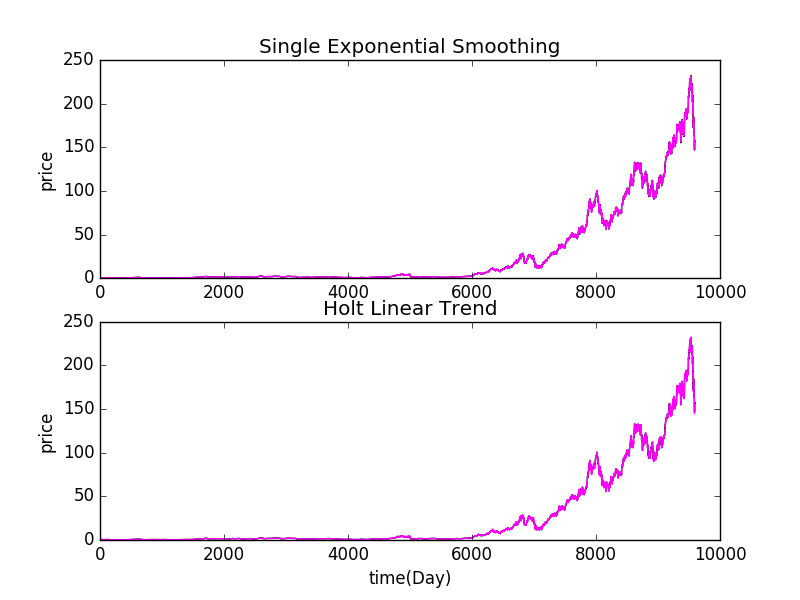

In [9]:
# Daily
viz(daily[0],daily[1],daily[2],'Day')

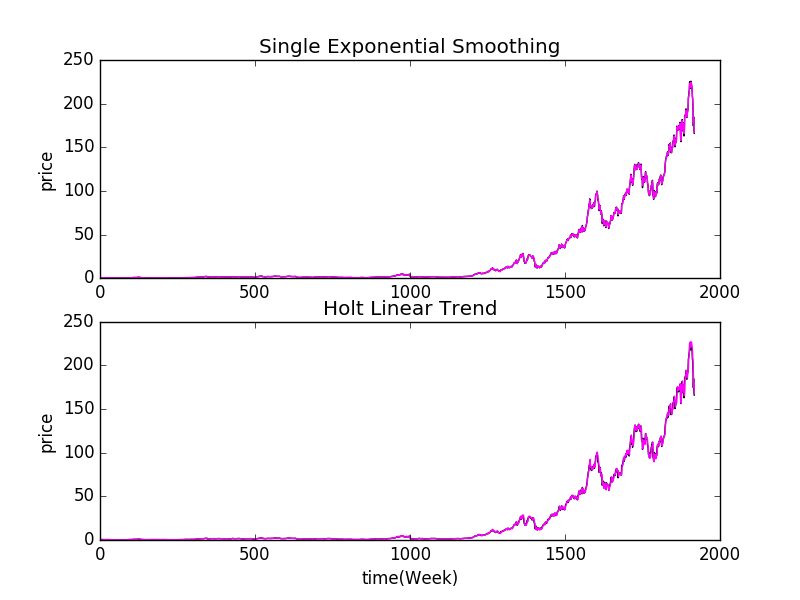

In [10]:
# Weekly
viz(weekly[0],weekly[1],weekly[2],'Week')

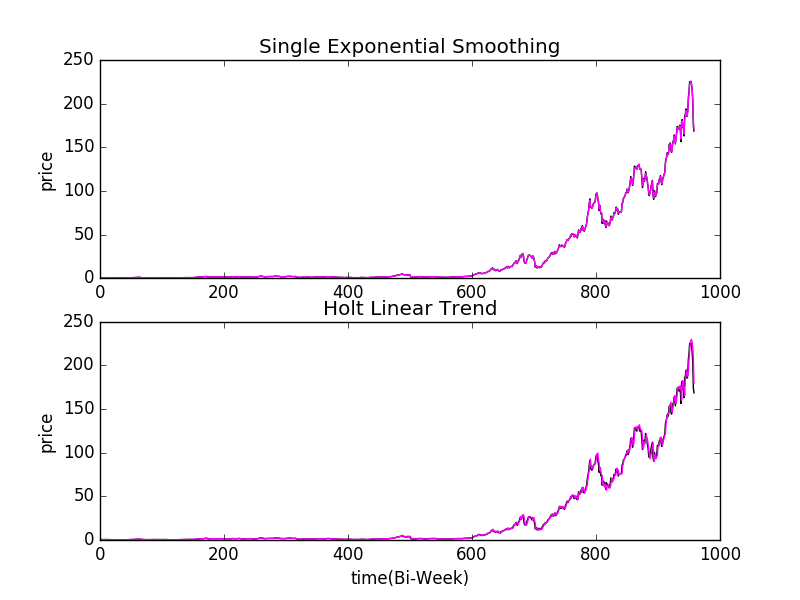

In [11]:
# Bi-Weekly
viz(biweekly[0],biweekly[1],biweekly[2],'Bi-Week')

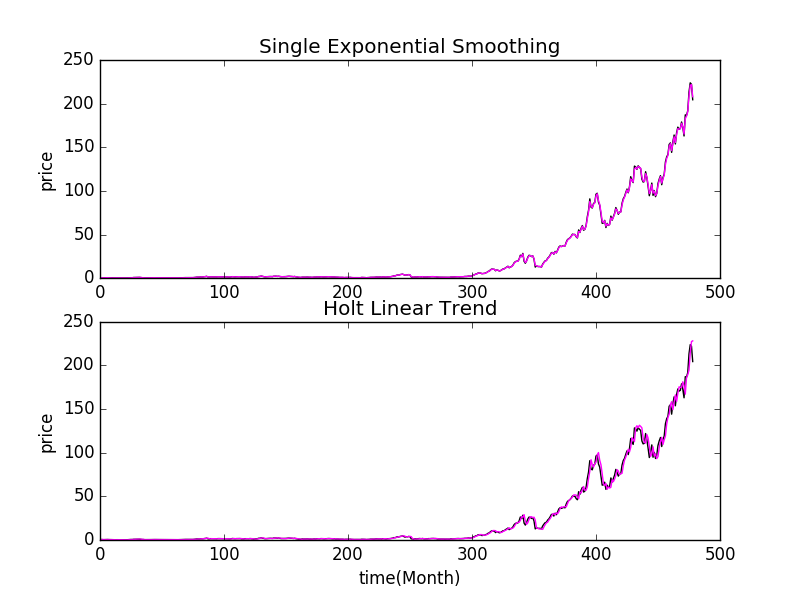

In [12]:
# Monthly
viz(monthly[0],monthly[1],monthly[2],'Month')

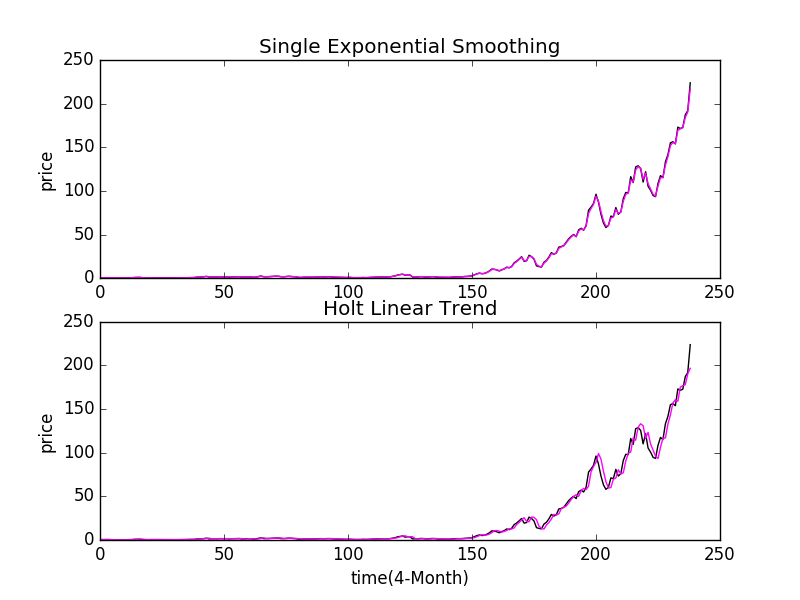

In [13]:
# Quad-Monthly
viz(quamonthly[0],quamonthly[1],quamonthly[2],'4-Month')

In [14]:
# --- Reference --- #
"""
https://machinelearningmastery.com/time-series-forecasting-performance-measures-with-python/
https://medium.com/datadriveninvestor/how-to-build-exponential-smoothing-models-using-python-simple-exponential-smoothing-holt-and-da371189e1a1
http://faculty.smu.edu/tfomby/eco5375/data/SMOOTHING%20MODELS_V6.pdf
https://otexts.com/fpp2/expsmooth.html
"""

Out[ 15 ]: '\nhttps://machinelearningmastery.com/time-series-forecasting-performance-measures-with-python/\nhttps://medium.com/datadriveninvestor/how-to-build-exponential-smoothing-models-using-python-simple-exponential-smoothing-holt-and-da371189e1a1\nhttp://faculty.smu.edu/tfomby/eco5375/data/SMOOTHING%20MODELS_V6.pdf\nhttps://otexts.com/fpp2/expsmooth.html\n'